In [1]:
import os
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import math
import geopandas as gp
import folium
from shapely.geometry import Point,LineString
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Specify directories

In [2]:
# UK Paths

# APC and GTFS
APC_Dir = r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\APC'
GTFS_Dir1 = r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\APC\gtfs_april23'
GTFS_Dir2 = r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\APC\gtfs_may13'

# Manually Matched Transit Stop Pairs

# Read in the list of stop pairs manually identified that are patially overlap with cmp segments
overlap_pairs = pd.read_csv(r'S:\CMP\Transit\Speed\Postprocessing_overlapping_transit_segments.csv')

# CMP network
NETCONF_DIR = r'Z:\SF_CMP\CMP2021\CMP_plus_shp'
cmp_segs_org=gp.read_file(os.path.join(NETCONF_DIR, 'cmp_segments_plus.shp'))

# INRIX network
INRIX_DIR = r'Z:\SF_CMP\CMP2021\Inrix_XD_2101_SF_manualedit'
inrix_net=gp.read_file(os.path.join(INRIX_DIR, 'Inrix_XD_2101_SF_manualedit.shp'))

# Conflation file
NETCONF_DIR = r'Z:\SF_CMP\CMP2021'
cmp_inrix_corr = pd.read_csv(os.path.join(NETCONF_DIR, 'CMP_Segment_INRIX_Links_Correspondence_2101_Manual_PLUS_Updated.csv'))

In [ ]:
# SFCTA Paths
#MAIN_DIR = r'Q:\CMP\LOS Monitoring 2019\Transit\Speed'
#NETCONF_DIR = r'Q:\CMP\LOS Monitoring 2019\Network_Conflation'
#APC_FILE = r'Q:\Data\Observed\Transit\Muni\APC\CMP_2019\APC_2019_SPRING.txt'

# GTFS QAQC

## Transit Stops 

In [3]:
def generate_transit_stops_geo(stop_dir):
    stops=pd.read_csv(os.path.join(stop_dir, 'stops.txt'))
    stops['stop_name'] = stops['stop_name'].str.lower()
    stops[['street_1','street_2']] = stops.stop_name.str.split(' & ', expand=True)  #split stop name into operating street and intersecting street
    stops['geometry'] = list(zip(stops.stop_lon, stops.stop_lat))
    stops['geometry'] = stops['geometry'].apply(Point)
    stops = gp.GeoDataFrame(stops, geometry='geometry', crs={'init': 'epsg:4326'})
    return stops

In [4]:
stops_april = generate_transit_stops_geo(GTFS_Dir1)
stops_april.head(1)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,street_1,street_2,geometry
0,390,10390,19th avenue & holloway st,,37.72119,-122.475096,,,19th avenue,holloway st,POINT (-122.475096 37.72119)


In [5]:
stops_may = generate_transit_stops_geo(GTFS_Dir2)

In [6]:
# Save converted stops shapefile to view in ArcGIS
stops_april.to_file(os.path.join(APC_Dir, 'stops_april23.shp'))
stops_may.to_file(os.path.join(APC_Dir, 'stops_may13.shp'))

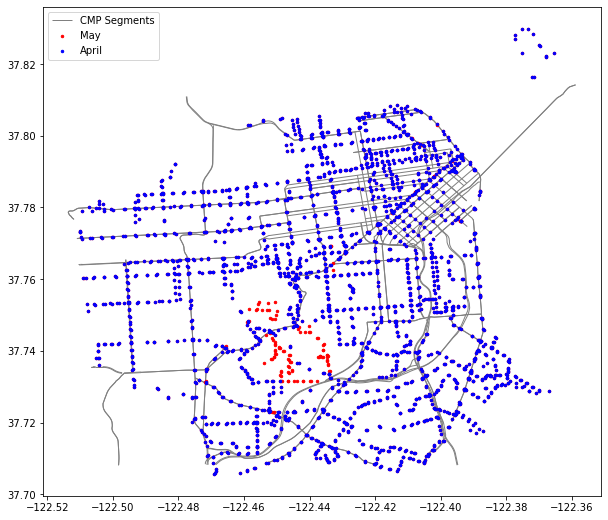

In [7]:
fig, ax = plt.subplots(figsize=(10,9))
cmp_segs_org.plot(ax=ax, color='grey', lw=1, label='CMP Segments',zorder=1)
stops_may.plot(ax=ax, marker='o', color='red', markersize=6, label='May', zorder=2)
stops_april.plot(ax=ax, marker='o', color='blue', markersize=6, label='April', zorder=3)
plt.legend()
plt.show()

### View transit stops on a street on map 

In [130]:
st_name = 'lombard st'   # change street name here. Make sure it's consistent with the street name in stop_name in stops file
stops_st = stops_may[stops_may['street_1']== (st_name)]

In [10]:
sf_coords = (37.774, -122.431)
def generateBaseMap():
    base_map = folium.Map(location=sf_coords, zoom_start=12,
                          tiles = 'Stamen Toner',
                          control_scale=True, 
                          preferCanvas = True
                         )
    return base_map

In [133]:
if len(stops_st) == 0:
    print('No transit stops found on this street!')
else:
    base_map = generateBaseMap()
    for idx in stops_st.index.tolist():
        lat = stops_st.loc[idx, 'stop_lat']
        long = stops_st.loc[idx, 'stop_lon']
        stopid = stops_st.loc[idx, 'stop_id']
        folium.Marker(
          location = [lat, long], 
          tooltip  = 'stop_id:' + str(stopid),
          icon = folium.Icon(color='blue', icon='fa-circle', prefix='fa')
         ).add_to(base_map) 
    display(base_map)

## Transit Trips 

In [13]:
def generate_transit_shapes_geo(stop_dir):
    shapes=pd.read_csv(os.path.join(stop_dir, 'shapes.txt'))
    shapes_gdf = pd.DataFrame()
    shape_ids = shapes.shape_id.unique().tolist()
    rid = 0
    for shpid in shape_ids:
        shp = shapes[shapes['shape_id']==shpid].sort_values(by='shape_pt_sequence')
        linestr = LineString(zip(shp.shape_pt_lon, shp.shape_pt_lat))
        linestr = gp.GeoDataFrame(index=[shpid], crs='epsg:4326', geometry=[linestr]) 
        shapes_gdf = shapes_gdf.append(linestr)
        rid = rid + 1
    shapes_gdf = shapes_gdf.reset_index()
    shapes_gdf.columns = ['shape_id', 'geometry']
    
    trips = pd.read_csv(os.path.join(stop_dir, 'trips.txt'))
    trips_shapes = shapes_gdf[shapes_gdf['shape_id'].isin(trips['shape_id'])]
    return trips, trips_shapes

In [14]:
trips_april, trips_shapes_april = generate_transit_shapes_geo(GTFS_Dir1)
print('number of trips: ', len(trips_april))
trips_april.head(2)

number of trips:  20957


,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,16266,3,9736781,Presidio Avenue,0,162,184033
1,16266,3,9736783,Presidio Avenue,0,161,184033


In [15]:
trips_may, trips_shapes_may = generate_transit_shapes_geo(GTFS_Dir2)
print('number of trips: ', len(trips_may))

number of trips:  41169


In [16]:
# Save converted shapes shapefile to view in ArcGIS
trips_shapes_april.to_file(os.path.join(APC_Dir, 'trips_shapes_april23.shp'))
trips_shapes_may.to_file(os.path.join(APC_Dir, 'trips_shapes_may13.shp'))

In [17]:
stop_times_april = pd.read_csv(os.path.join(GTFS_Dir1, 'stop_times.txt'))
print('number of stop times: ', len(stop_times_april))
stop_times_april.head(1)

number of stop times:  813803


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,9736053,21:55:00,21:55:00,4015,1,,,,


In [144]:
stop_times_may = pd.read_csv(os.path.join(GTFS_Dir2, 'stop_times.txt'))
print('number of stop times: ', len(stop_times_may))

number of stop times:  1603510


In [145]:
stop_times_may['arvltime'] = stop_times_may['arrival_time'].apply(lambda x: int(x[0:2]) + int(x[3:5])/60 + int(x[6:8])/3600)

In [148]:
stop_times_cmp = stop_times_may[((stop_times_may['arvltime']>=7) & (stop_times_may['arvltime']<=9)) | 
                                ((stop_times_may['arvltime']>=16.5) & (stop_times_may['arvltime']<=18.5))]

In [150]:
# transit stops that have services planned
stops_may_serviced = stops_may[stops_may['stop_id'].isin(stop_times_cmp['stop_id'])]
stops_may_serviced.to_file(os.path.join(APC_Dir, 'stops_may13_serviced.shp'))

In [149]:
stop_times_cmp.head(2)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,arvltime
0,9873130,17:29:00,17:29:00,7842,1,NaN,NaN,NaN,NaN,NaN,17.483333
1,9873130,17:32:00,17:32:00,7099,2,NaN,NaN,NaN,NaN,NaN,17.533333


In [209]:
def display_trips_passing_a_stop(cur_stop):
    stop_trips = stop_times_may[stop_times_may['stop_id']==cur_stop]  #all the planned trips that pass this transit stop
    if len(stop_trips)== 0:
        print('No trips are found that stop at this transit stop!')
    else:
        base_map = generateBaseMap()
        
        stop_trips_shapes = trips_may[trips_may['trip_id'].isin(stop_trips['trip_id'])]
        if len(trips_shapes_may[trips_shapes_may['shape_id'].isin(stop_trips_shapes['shape_id'])]) == 0:
            print('No shapes are found for these trips')
        else:
            
            stop_trips_unique_shapes_idx = trips_shapes_may.index[trips_shapes_may['shape_id'].isin(stop_trips_shapes['shape_id'])]
            print('There are %s different shapes for these trips' % len(stop_trips_unique_shapes_idx))
            for idx in stop_trips_unique_shapes_idx:
                coords = list(zip(trips_shapes_may.loc[idx, 'geometry'].coords.xy[1], trips_shapes_may.loc[idx, 'geometry'].coords.xy[0]))
                folium.PolyLine(locations=coords, 
                                tooltip  = 'shape_id:' + str(trips_shapes_may.loc[idx, 'shape_id']),
                                weight=5, line_color='red').add_to(base_map) 
        trips_pass_stops = stop_times_may[stop_times_may['trip_id'].isin(stop_trips['trip_id'])]
        trips_pass_stops_unique = stops_may[stops_may['stop_id'].isin(trips_pass_stops['stop_id'])]
        for idx in trips_pass_stops_unique.index.tolist():
            lat = trips_pass_stops_unique.loc[idx, 'stop_lat']
            long = trips_pass_stops_unique.loc[idx, 'stop_lon']
            stopid = trips_pass_stops_unique.loc[idx, 'stop_id']
            folium.Marker(
              location = [lat, long], 
              tooltip  = 'stop_id:' + str(stopid),
              icon = folium.Icon(color='blue', icon='fa-circle', prefix='fa')
             ).add_to(base_map) 
        
        display(base_map)

In [210]:
# display all the scheduled trips that pass a certain stop and the shapes of these trips
# Note: trips and shapes may overlap

cur_stop = 6043   # change the stop_id here. 
display_trips_passing_a_stop(cur_stop)

There are 6 different shapes for these trips


# APC data

In [21]:
vol = pd.read_csv(os.path.join(APC_Dir, 'APC_STOP_BOARDINGS_FACTS_SFCTACMP2021.csv'))

In [22]:
len(vol)

17717726

In [23]:
vol_notnull = vol[pd.notnull(vol['CLOSE_DATE_TIME'])]

In [24]:
vol_notnull['Date']=pd.to_datetime(vol_notnull['ACTUALDATE'])
vol_notnull['DOW']=vol_notnull.Date.dt.dayofweek #Mon-0
vol_notnull['DayType'] = np.where(vol_notnull['DOW']<=4, 'Weekdays', np.where(vol_notnull['DOW']==5, 'Saturday', 'Sunday'))
vol_notnull['Month']=vol_notnull.Date.dt.month
vol_notnull['Day']=vol_notnull.Date.dt.day

vol_notnull['Close_Hour'] = vol_notnull['CLOSE_DATE_TIME'].str[10:12].astype(int)
vol_notnull['Close_Minute'] = vol_notnull['CLOSE_DATE_TIME'].str[13:15].astype(int)
vol_notnull['Close_Second'] = vol_notnull['CLOSE_DATE_TIME'].str[16:18].astype(int)
vol_notnull['Close_Period'] = vol_notnull['CLOSE_DATE_TIME'].str[-2:]
vol_notnull['Close_Time'] = vol_notnull['Date'].astype('str') + ' ' + vol_notnull['Close_Hour'].astype('str') + ':' + vol_notnull['Close_Minute'].astype('str') + ':' + vol_notnull['Close_Second'].astype('str') + ' ' + vol_notnull['Close_Period']
vol_notnull['Close_Time'] = pd.to_datetime(vol_notnull['Close_Time'])

vol_notnull['Epoch'] = 2*vol_notnull['Close_Time'].dt.hour + vol_notnull['Close_Time'].dt.minute//30 

In [27]:
# CMP monitoring dates
vol_notnull = vol_notnull[((vol_notnull['Month']==4) & (vol_notnull['Day'] > 5)) | ((vol_notnull['Month']==5) & (vol_notnull['Day'] < 21))]

## Check whether APC data exist for a certain transit stop 

In [211]:
def display_actual_apc_trip_and_shape(trip_id, date):
    one_trip_stops = vol_notnull[(vol_notnull['TRIP_ID_EXTERNAL']==trip_id) & (vol_notnull['Date']==date)]
    if len(one_trip_stops) == 0:
        print('No transit stops found on this trip!')
    else:
        base_map = generateBaseMap()

        stop_trips_shapes = trips_may[trips_may['trip_id']==trip_id]
        stop_trips_unique_shapes_idx = trips_shapes_may.index[trips_shapes_may['shape_id'].isin(stop_trips_shapes['shape_id'])]
        for idx in stop_trips_unique_shapes_idx:
            coords = list(zip(trips_shapes_may.loc[idx, 'geometry'].coords.xy[1], trips_shapes_may.loc[idx, 'geometry'].coords.xy[0]))
            folium.PolyLine(locations=coords, 
                            tooltip  = 'shape_id:' + str(trips_shapes_may.loc[idx, 'shape_id']),
                            weight=5, line_color='red').add_to(base_map) 

        for idx in one_trip_stops.index.tolist():
            lat = one_trip_stops.loc[idx, 'VEH_LAT']
            long = one_trip_stops.loc[idx, 'VEH_LONG']
            stopid = one_trip_stops.loc[idx, 'BS_ID']
            folium.Marker(
              location = [lat, long], 
              tooltip  = 'stop_id:' + str(stopid),
              icon = folium.Icon(color='blue', icon='fa-circle', prefix='fa')
             ).add_to(base_map) 
        display(base_map)

In [191]:
vol_notnull[vol_notnull['BS_ID']==4516]

,ACTUALDATE,SERVICE_DAY_OF_WEEK,PRIMARY_KEY,EFFECTIVE_DATE_KEY,TRAP_SIGN_ID,BOOKING_ID,TRAP_PATTERN_NAME,BLOCK_NUM_EXTERNAL,TRAP_BUS_TYPE_ID,ROUTE_ALPHA,DIRECTION,TRIP_ID_EXTERNAL,START_TIME,END_TIME,TRIP_START_TIME,TRIP_START_HOUR,SCHED_RUNNING_TIME_SECONDS,TOTAL_TRIP_DISTANCE,STOP_LINE_SEQUENCE,BS_ID,IS_TERMINAL_INITIAL,ROUTE_SEGMENT_ID,ACCUM_DISTANCE,SCHEDULE_LOAD_DATE,APC_SOURCE,VEHICLE_ID,ACTUAL_SEQUENCE,RUN_ID,OPERATOR_ID,STOP_ARRIVAL_HOUR,OPEN_DATE_TIME,CLOSE_DATE_TIME,DWELL_TIME,ONS,OFFS,MAX_LOAD,REV_DISTANCE,NON_REV_DISTANCE,REV_SECONDS,NON_REV_SECONDS,PASSENGER_MILES,PASSENGER_HOURS,VEH_LAT,VEH_LONG,IMPORT_ERROR,IMPORT_TRIP_ERROR,CALC_SPEED,IS_TRIP_SAMPLED,STOPS_SAMPLED,ACTIVITY_LOAD_DATE,Date,DOW,DayType,Month,Day,Close_Hour,Close_Minute,Close_Second,Close_Period,Close_Time,Epoch,Open_Hour,Open_Minute,Open_Second,Open_Period,Open_Time


In [186]:
embarcadero_stops = [4532, 4534, 4503, 4504, 4517, 4518, 4515, 4516, 4529, 7281, 4501, 4502, 4513, 7283]  #no APC data
embarcadero_stops= [ 4508, 4509, 4510, 4511, 4531, 7447, 4506, 7145] # have APC data
len(vol_notnull[vol_notnull['BS_ID'].isin(embarcadero_stops)])

21409

In [213]:
vol_notnull[vol_notnull['BS_ID'].isin(embarcadero_stops)].head(1)

,ACTUALDATE,SERVICE_DAY_OF_WEEK,PRIMARY_KEY,EFFECTIVE_DATE_KEY,TRAP_SIGN_ID,BOOKING_ID,TRAP_PATTERN_NAME,BLOCK_NUM_EXTERNAL,TRAP_BUS_TYPE_ID,ROUTE_ALPHA,DIRECTION,TRIP_ID_EXTERNAL,START_TIME,END_TIME,TRIP_START_TIME,TRIP_START_HOUR,SCHED_RUNNING_TIME_SECONDS,TOTAL_TRIP_DISTANCE,STOP_LINE_SEQUENCE,BS_ID,IS_TERMINAL_INITIAL,ROUTE_SEGMENT_ID,ACCUM_DISTANCE,SCHEDULE_LOAD_DATE,APC_SOURCE,VEHICLE_ID,ACTUAL_SEQUENCE,RUN_ID,OPERATOR_ID,STOP_ARRIVAL_HOUR,OPEN_DATE_TIME,CLOSE_DATE_TIME,DWELL_TIME,ONS,OFFS,MAX_LOAD,REV_DISTANCE,NON_REV_DISTANCE,REV_SECONDS,NON_REV_SECONDS,PASSENGER_MILES,PASSENGER_HOURS,VEH_LAT,VEH_LONG,IMPORT_ERROR,IMPORT_TRIP_ERROR,CALC_SPEED,IS_TRIP_SAMPLED,STOPS_SAMPLED,ACTIVITY_LOAD_DATE,Date,DOW,DayType,Month,Day,Close_Hour,Close_Minute,Close_Second,Close_Period,Close_Time,Epoch,Open_Hour,Open_Minute,Open_Second,Open_Period,Open_Time
1431132,06-APR-21 00:00:00,WEEKDAY,216023905,3748,125,210320 001,NBUS O F10,7019,16.0,NBUS,OUTBOUND,9823509,16-MAR-21 01.40.00.000000000 PM,16-MAR-21 02.40.00.000000000 PM,13:40:00,13,3600,9.6,4,7447,INTRANSIT,1,0.88897,25-JUL-21 00:00:00,RADIO,6594.0,3.0,8409.0,5854.0,13.0,06-APR-21 01.44.04.000000000 PM,06-APR-21 01.44.23.000000000 PM,19.0,2.0,0.0,2.0,0.997658,0.0,333.0,0.0,1.995316,0.185,37.7843,-122.38797,0,0,10.785492,1,28,25-JUL-21 00:00:00,2021-04-06,1,Weekdays,4,6,1,44,23,PM,2021-04-06 13:44:23,27,1,44,4,PM,2021-04-06 13:44:04


In [214]:
trip_id, date = 9823509, '2021-04-06'  # Use trip_id from TRIP_ID_EXTERNAL column in vol_notnull dataframe
display_actual_apc_trip_and_shape(trip_id, date)

In [215]:
bryant_stops = [3724, 3725, 3723, 4436]
len(apc_cmp_am[apc_cmp_am['BS_ID'].isin(bryant_stops)])

701

In [197]:
apc_cmp_am[apc_cmp_am['BS_ID'].isin(bryant_stops)].head(2)

,index,ACTUALDATE,SERVICE_DAY_OF_WEEK,PRIMARY_KEY,EFFECTIVE_DATE_KEY,TRAP_SIGN_ID,BOOKING_ID,TRAP_PATTERN_NAME,BLOCK_NUM_EXTERNAL,TRAP_BUS_TYPE_ID,ROUTE_ALPHA,DIRECTION,TRIP_ID_EXTERNAL,START_TIME,END_TIME,TRIP_START_TIME,TRIP_START_HOUR,SCHED_RUNNING_TIME_SECONDS,TOTAL_TRIP_DISTANCE,STOP_LINE_SEQUENCE,BS_ID,IS_TERMINAL_INITIAL,ROUTE_SEGMENT_ID,ACCUM_DISTANCE,SCHEDULE_LOAD_DATE,APC_SOURCE,VEHICLE_ID,ACTUAL_SEQUENCE,RUN_ID,OPERATOR_ID,STOP_ARRIVAL_HOUR,OPEN_DATE_TIME,CLOSE_DATE_TIME,DWELL_TIME,ONS,OFFS,MAX_LOAD,REV_DISTANCE,NON_REV_DISTANCE,REV_SECONDS,NON_REV_SECONDS,PASSENGER_MILES,PASSENGER_HOURS,VEH_LAT,VEH_LONG,IMPORT_ERROR,IMPORT_TRIP_ERROR,CALC_SPEED,IS_TRIP_SAMPLED,STOPS_SAMPLED,ACTIVITY_LOAD_DATE,Date,DOW,DayType,Month,Day,Close_Hour,Close_Minute,Close_Second,Close_Period,Close_Time,Epoch,Open_Hour,Open_Minute,Open_Second,Open_Period,Open_Time,Open_Time_float,Close_Time_float,stop_lat,stop_code,stop_lon,stop_url,stop_id,stop_desc,stop_name,location_type,zone_id,street_1,street_2,geometry,near_cmp,near_dis
45606,11380,06-APR-21 00:00:00,WEEKDAY,215790165,3748,125,210320 001,8 I F00,812,16.0,008,INBOUND,9745184,16-MAR-21 08.20.00.000000000 AM,16-MAR-21 09.27.00.000000000 AM,08:20:00,8,4020,11.3,45,3725,INTRANSIT,6,8.34817,25-JUL-21 00:00:00,RADIO,6547.0,28.0,8238.0,5098.0,8.0,06-APR-21 08.59.33.000000000 AM,06-APR-21 08.59.54.000000000 AM,21.0,0.0,2.0,38.0,0.175189,0.0,58.0,0.0,6.657182,0.612222,37.776165,-122.402214,0,0,10.873800,1,40,25-JUL-21 00:00:00,2021-04-06,1,Weekdays,4,6,8,59,54,AM,2021-04-06 08:59:54,17,8,59,33,AM,2021-04-06 08:59:33,8.992500,8.998333,37.776157,13725.0,-122.402231,NaN,3725.0,NaN,bryant st & 6th st,0.0,NaN,bryant st,6th st,POINT (1832439.191837895 643332.1236801039),1.0,7.547542
45630,50816,13-APR-21 00:00:00,WEEKDAY,217829091,3755,125,210320 001,8 I F00,812,16.0,008,INBOUND,9745184,16-MAR-21 08.20.00.000000000 AM,16-MAR-21 09.27.00.000000000 AM,08:20:00,8,4020,11.3,45,3725,INTRANSIT,6,8.34817,25-JUL-21 00:00:00,RADIO,6570.0,25.0,8238.0,5098.0,8.0,13-APR-21 08.58.06.000000000 AM,13-APR-21 08.58.13.000000000 AM,7.0,0.0,1.0,42.0,0.322233,0.0,73.0,0.0,13.533786,0.851667,37.776165,-122.402214,0,0,15.890943,1,36,25-JUL-21 00:00:00,2021-04-13,1,Weekdays,4,13,8,58,13,AM,2021-04-13 08:58:13,17,8,58,6,AM,2021-04-13 08:58:06,8.968333,8.970278,37.776157,13725.0,-122.402231,NaN,3725.0,NaN,bryant st & 6th st,0.0,NaN,bryant st,6th st,POINT (1832439.191837895 643332.1236801039),1.0,7.547542


In [216]:
trip_id, date = 9745184, '2021-04-06'
display_actual_apc_trip_and_shape(trip_id, date)

In [217]:
trip_id, date = 9747897, '2021-04-06'
display_actual_apc_trip_and_shape(trip_id, date)

## Check weekday daily average boardings 

In [28]:
boarding_daily = vol_notnull.groupby(['Month', 'DayType', 'Date']).ONS.sum().reset_index()
boarding_daily_avg = boarding_daily.groupby(['Month', 'DayType']).ONS.mean().reset_index()

In [29]:
boarding_daily_avg

,Month,DayType,ONS
0,4,Saturday,129447.000000
1,4,Sunday,105091.333333
2,4,Weekdays,170881.894737
3,5,Saturday,129745.333333
4,5,Sunday,111363.333333
5,5,Weekdays,179400.214286


# Volume

In [30]:
vol_sum = vol_notnull.groupby(['BS_ID', 'Date', 'Epoch']).agg({'ONS': 'sum', 'OFFS': 'sum', 'MAX_LOAD': 'sum', 'Close_Period':'count'}).reset_index()
vol_sum.columns = ['stopid', 'date', 'epoch', 'boardings', 'alightings', 'loads', 'samples']

In [31]:
vol_sum['date']=pd.to_datetime(vol_sum['date'])
vol_sum['dow']=vol_sum.date.dt.dayofweek #Mon-0
vol_sum['daytype'] = np.where(vol_sum['dow']<=4, 'Weekdays', np.where(vol_sum['dow']==5, 'Saturday', 'Sunday'))

# Remove Mondays and Fridays to get typical weekdays
print('Number of records', len(vol_sum))
vol_sum = vol_sum[(vol_sum['dow']!=0) & (vol_sum['dow']!=4)]
print('Number of records', len(vol_sum))

Number of records 1934011
Number of records 1383413


In [32]:
vol_daytype_avg_stops = vol_sum.groupby(['stopid', 'daytype', 'epoch']).agg({'boardings': 'mean', 
                                                                             'alightings': 'mean',
                                                                            'loads': 'mean'}).reset_index()
vol_daytype_avg_stops.columns= ['stopid', 'daytype', 'epoch', 'boardings', 'alightings', 'loads']
vol_daytype_avg_stops.head()

,stopid,daytype,epoch,boardings,alightings,loads
0,390,Saturday,0,1.0,0.0,1.0
1,390,Saturday,2,2.0,0.0,2.0
2,390,Saturday,3,6.4,3.8,2.6
3,390,Saturday,4,0.5,0.0,0.5
4,390,Saturday,5,1.0,0.0,1.0


In [33]:
stops = stops_may.copy()

In [34]:
# Create empty dataframe with continuous time periods
df_epoch = pd.DataFrame([ep for ep in range(48)], columns=['epoch'])
df_epoch['hour'] = df_epoch['epoch']//2
df_epoch['minute'] = np.where(df_epoch['epoch']%2 ==0, '00', '30')
df_epoch['period'] = df_epoch['hour'].astype(str) + ':' + df_epoch['minute']

daytypes = ['Weekdays', 'Saturday', 'Sunday']
df_day_epoch = pd.DataFrame()
for day_type in daytypes:
    df_epoch['daytype'] = day_type
    df_day_epoch = df_day_epoch.append(df_epoch, ignore_index=True)

stop_list = stops.stop_id.unique().tolist()
stop_vol_complete = pd.DataFrame()
for stop_id in stop_list:
    df_day_epoch['stopid'] = stop_id
    stop_vol_complete = stop_vol_complete.append(df_day_epoch, ignore_index=True)

stop_vol_complete['epoch'] = stop_vol_complete['epoch'].astype(int)

In [36]:
stop_vol_complete = pd.merge(stop_vol_complete, vol_daytype_avg_stops, on=['stopid', 'daytype', 'epoch'], how='left')

In [37]:
stop_vol_complete['hour'] = stop_vol_complete['epoch']//2
stop_vol_complete['minute'] = np.where(stop_vol_complete['epoch']%2 ==0, '00', '30')

In [38]:
stop_vol_complete['period'] = stop_vol_complete['hour'].astype(str) + ':' + stop_vol_complete['minute']

In [39]:
stop_vol_complete.to_csv(os.path.join(APC_Dir, 'CMP_APC_Average_Transit_Volume_QAQC.csv'), index=False)

# Speed

In [40]:
#Define WGS 1984 coordinate system
wgs84 = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

#Define NAD 1983 StatePlane California III
cal3 = {'proj': 'lcc +lat_1=37.06666666666667 +lat_2=38.43333333333333 +lat_0=36.5 +lon_0=-120.5 +x_0=2000000 +y_0=500000.0000000002', 'ellps': 'GRS80', 'datum': 'NAD83', 'no_defs': True}

In [41]:
# Convert original coordinate system to state plane
stops = stops.to_crs(cal3)

cmp_segs_prj = cmp_segs_org.to_crs(cal3)
cmp_segs_prj['cmp_name'] = cmp_segs_prj['cmp_name'].str.replace('/ ','/')
cmp_segs_prj['cmp_name'] = cmp_segs_prj['cmp_name'].str.lower()
cmp_segs_prj['Length'] = cmp_segs_prj.geometry.length 
cmp_segs_prj['Length'] = cmp_segs_prj['Length'] * 3.2808  #meters to feet

# INRIX network
inrix_net=gp.read_file(os.path.join(INRIX_DIR, 'Inrix_XD_2101_SF_manualedit.shp'))
inrix_net['RoadName'] = inrix_net['RoadName'].str.lower()

In [42]:
# Create a buffer zone for each cmp segment
ft=160   # According to the memo from last CMP cycle
mt=round(ft/3.2808,4)
stops_buffer=stops.copy()
stops_buffer['geometry'] = stops_buffer.geometry.buffer(mt)
#stops_buffer.to_file(os.path.join(MAIN_DIR, 'stops_buffer.shp'))

# cmp segments intersecting transit stop buffer zone
cmp_segs_intersect=gp.sjoin(cmp_segs_prj, stops_buffer, op='intersects').reset_index()

stops['near_cmp'] = 0
cmp_segs_intersect['name_match']=0
for stop_idx in range(len(stops)):
    stop_id = stops.loc[stop_idx, 'stop_id']
    stop_geo = stops.loc[stop_idx]['geometry']
    stop_names = stops.loc[stop_idx]['street_1'].split('/')
    if 'point lobos' in stop_names:
        stop_names = stop_names + ['geary']
    if stop_id == 7357:
        stop_names = stop_names + ['third st']
    
    cmp_segs_int = cmp_segs_intersect[cmp_segs_intersect['stop_id']==stop_id]
    cmp_segs_idx = cmp_segs_intersect.index[cmp_segs_intersect['stop_id']==stop_id].tolist()
    
    near_dis = 5000
    if ~cmp_segs_int.empty:
        for seg_idx in cmp_segs_idx:
            cmp_seg_id = cmp_segs_int.loc[seg_idx, 'cmp_segid']
            cmp_seg_geo = cmp_segs_int.loc[seg_idx]['geometry']
            cmp_seg_names = cmp_segs_int.loc[seg_idx]['cmp_name'].split('/')
            if 'bayshore' in cmp_seg_names:
                cmp_seg_names = cmp_seg_names + ['bay shore']
            if '3rd st' in cmp_seg_names:
                cmp_seg_names = cmp_seg_names + ['third st']
            if '19th ave' in cmp_seg_names:
                cmp_seg_names = cmp_seg_names + ['19th avenue']
            if 'geary' in cmp_seg_names:
                cmp_seg_names = cmp_seg_names + ['point lobos']
            if 'embarcadero' in cmp_seg_names:
                cmp_seg_names = cmp_seg_names + ['the embarcadero']
                
            
            # Add INRIX street name to be comprehensive
            inrix_links = cmp_inrix_corr[cmp_inrix_corr['CMP_SegID']==cmp_seg_id]
            inrix_link_names = inrix_net[inrix_net['XDSegID'].isin(inrix_links['INRIX_SegID'])]['RoadName'].tolist()
            inrix_link_names = list(filter(None, inrix_link_names)) 
            if len(inrix_link_names) > 0:
                inrix_link_names = list(set(inrix_link_names))
                cmp_seg_link_names = cmp_seg_names + inrix_link_names
            else:
                cmp_seg_link_names = cmp_seg_names
            
            matched_names= [stop_name for stop_name in stop_names if any(cname in stop_name for cname in cmp_seg_link_names)]
            if len(matched_names)>0:
                stops.loc[stop_idx, 'near_cmp']=1
                cmp_segs_intersect.loc[seg_idx, 'name_match']=1
                cur_dis = stop_geo.distance(cmp_seg_geo)
                cmp_segs_intersect.loc[seg_idx, 'distance']=cur_dis
                near_dis = min(near_dis, cur_dis)
                stops.loc[stop_idx, 'near_dis']=near_dis


stops_near_cmp = stops[stops['near_cmp']==1]
stops_near_cmp = stops_near_cmp.to_crs(wgs84)

stops_near_cmp_list = stops_near_cmp['stop_id'].unique().tolist()

cmp_segs_near = cmp_segs_intersect[cmp_segs_intersect['name_match']==1]

In [43]:
# Remove mismatched stops based on manual review
remove_cmp_stop = [(175, 5546), (175, 5547), (175, 7299), (175, 5544),
                  (66, 7744),
                  (214, 7235),
                  (107, 4735),
                  (115, 4275),
                  (143, 4824),
                  (172, 5603)]

In [44]:
for remove_idx in range(len(remove_cmp_stop)):
    rmv_cmp_id = remove_cmp_stop[remove_idx][0]
    rmv_stop_id = remove_cmp_stop[remove_idx][1]
    remove_df_idx = cmp_segs_near.index[(cmp_segs_near['cmp_segid']==rmv_cmp_id) & (cmp_segs_near['stop_id']==rmv_stop_id)].tolist()
    if len(remove_df_idx) > 0:
        cmp_segs_near = cmp_segs_near.drop([remove_df_idx[0]], axis=0)

In [45]:
vol_notnull['Open_Hour'] = vol_notnull['OPEN_DATE_TIME'].str[10:12].astype(int)
vol_notnull['Open_Minute'] = vol_notnull['OPEN_DATE_TIME'].str[13:15].astype(int)
vol_notnull['Open_Second'] = vol_notnull['OPEN_DATE_TIME'].str[16:18].astype(int)
vol_notnull['Open_Period'] = vol_notnull['OPEN_DATE_TIME'].str[-2:]
vol_notnull['Open_Time'] = vol_notnull['Date'].astype('str') + ' ' + vol_notnull['Open_Hour'].astype('str') + ':' + vol_notnull['Open_Minute'].astype('str') + ':' + vol_notnull['Open_Second'].astype('str') + ' ' + vol_notnull['Open_Period']
vol_notnull['Open_Time'] = pd.to_datetime(vol_notnull['Open_Time'])

apc_cmp = vol_notnull[(vol_notnull['DOW'] ==1) | (vol_notnull['DOW'] ==2) | (vol_notnull['DOW'] ==3)]  # only Tue, Wed, and Thu

In [46]:
apc_cmp['Day']=apc_cmp.Date.dt.day
apc_cmp = apc_cmp[((apc_cmp['Month']==4) & (apc_cmp['Day'] > 5)) | ((apc_cmp['Month']==5) & (apc_cmp['Day'] < 21))] # CMP monitoring dates

#apc_cmp['Open_Hour'] = apc_cmp.Open_Time.dt.hour
#apc_cmp['Close_Hour'] = apc_cmp.Close_Time.dt.hour
apc_cmp['Open_Time_float'] = apc_cmp['Open_Hour'] + apc_cmp['Open_Minute']/60 + apc_cmp['Open_Second']/3600
apc_cmp['Close_Time_float'] = apc_cmp['Close_Hour'] + apc_cmp['Close_Minute']/60 + apc_cmp['Close_Second']/3600

In [67]:
# # Match AM&PM transit stops to CMP segments
angle_thrd = 10
def match_stop_pairs_to_cmp(apc_cmp_df, stops_near_cmp_list, cmp_segs_near, cmp_segs_prj, angle_thrd):
    apc_pairs_df = pd.DataFrame()
    pair_cnt = 0
    for cur_stop_idx in range(len(apc_cmp_df)-2):  #Enumerate the records in apc_cmp_df
        # Check if the stop_id is in the previously matched list
        if apc_cmp_df.loc[cur_stop_idx, 'stop_id'] in stops_near_cmp_list:
            next_stop_match = 0
            if apc_cmp_df.loc[cur_stop_idx + 1, 'stop_id'] in stops_near_cmp_list:
                next_stop_idx = cur_stop_idx + 1 
                next_stop_match = 1
            # This is to ensure the stop_id associated with cur_stop_idx + 2 is also checked when the stop_id associated with cur_stop_idx + 1 is not found in the matched list
            elif apc_cmp_df.loc[cur_stop_idx + 2, 'stop_id'] in stops_near_cmp_list:
                next_stop_idx = cur_stop_idx +2
                next_stop_match = 2

            if next_stop_match >0:
                # Transit stop of interest
                cur_stop_trip_id = apc_cmp_df.loc[cur_stop_idx, 'TRIP_ID_EXTERNAL']
                cur_stop_date = apc_cmp_df.loc[cur_stop_idx, 'Date']
                cur_stop_veh_id = apc_cmp_df.loc[cur_stop_idx, 'VEHICLE_ID']
                cur_stop_route_alpha = apc_cmp_df.loc[cur_stop_idx, 'ROUTE_ALPHA']
                cur_stop_route_dir = apc_cmp_df.loc[cur_stop_idx, 'DIRECTION']

                # Succeeding candidate stop in the dataframe
                next_stop_trip_id = apc_cmp_df.loc[next_stop_idx, 'TRIP_ID_EXTERNAL']
                next_stop_date = apc_cmp_df.loc[next_stop_idx, 'Date']
                next_stop_veh_id = apc_cmp_df.loc[next_stop_idx, 'VEHICLE_ID']

                # Check if two stops share the same trip id, date, and vehicle id
                if (cur_stop_trip_id == next_stop_trip_id) & (cur_stop_date == next_stop_date) & (cur_stop_veh_id == next_stop_veh_id):

                    cur_stop_id = apc_cmp_df.loc[cur_stop_idx, 'stop_id']
                    cur_stop_open_time = apc_cmp_df.loc[cur_stop_idx, 'Open_Time']
                    cur_stop_close_time = apc_cmp_df.loc[cur_stop_idx, 'Close_Time']
                    cur_stop_dwell_time = apc_cmp_df.loc[cur_stop_idx, 'DWELL_TIME']

                    next_stop_id = apc_cmp_df.loc[next_stop_idx, 'stop_id']
                    next_stop_open_time = apc_cmp_df.loc[next_stop_idx, 'Open_Time']
                    next_stop_close_time = apc_cmp_df.loc[next_stop_idx, 'Close_Time']
                    next_stop_dwell_time = apc_cmp_df.loc[next_stop_idx, 'DWELL_TIME']

                    # Matched CMP segments for the current stop
                    cur_stop_near_segs = list(cmp_segs_near[cmp_segs_near['stop_id']==cur_stop_id]['cmp_segid'])
                    # Matched CMP segments for the succeeding stop
                    next_stop_near_segs = list(cmp_segs_near[cmp_segs_near['stop_id']==next_stop_id]['cmp_segid'])

                    # Find the common CMP segments in two sets
                    common_segs = list(set(cur_stop_near_segs) & set(next_stop_near_segs))
                    
                    if len(common_segs)>0:
                        cur_stop_geo = apc_cmp_df.loc[cur_stop_idx]['geometry']   # location geometry of current stop
                        next_stop_geo = apc_cmp_df.loc[next_stop_idx]['geometry']  # location geometry of succeeding stop

                        # Traveling direction from current stop to succeeding stop
                        stop_degree=(180 / math.pi) * math.atan2(next_stop_geo.x - cur_stop_geo.x, next_stop_geo.y - cur_stop_geo.y)

                        for common_seg_id in common_segs: # Iterate through the common segments set
                            common_seg_geo = cmp_segs_prj[cmp_segs_prj['cmp_segid']==common_seg_id]['geometry']  # line geometry of the cmp segment

                            cur_stop_dis = common_seg_geo.project(cur_stop_geo)  # distance between the beginning point of cmp segment and the projected transit stop
                            cur_stop_projected = common_seg_geo.interpolate(cur_stop_dis) #project current stop onto cmp segment
                            cur_stop_loc = cur_stop_dis * 3.2808  #meters to feet

                            next_stop_dis = common_seg_geo.project(next_stop_geo)
                            next_stop_projected = common_seg_geo.interpolate(next_stop_dis) #project next stop onto cmp segment
                            next_stop_loc = next_stop_dis * 3.2808  #meters to feet

                            # Ensure the degree is calculated following the traveling direction
                            if float(next_stop_loc) > float(cur_stop_loc):
                                cmp_degree=(180 / math.pi) * math.atan2(next_stop_projected.x - cur_stop_projected.x, next_stop_projected.y - cur_stop_projected.y)
                            else:
                                cmp_degree=(180 / math.pi) * math.atan2(cur_stop_projected.x - next_stop_projected.x, cur_stop_projected.y - next_stop_projected.y)

                            stop_cmp_angle = abs(cmp_degree-stop_degree)
                            if stop_cmp_angle>270:
                                stop_cmp_angle=360-stop_cmp_angle

                            if stop_cmp_angle < angle_thrd:   # Angle between CMP segment and transit stop pair meets the requirement
                                cur_next_traveltime = (next_stop_open_time-cur_stop_open_time).total_seconds()
                                cur_next_loc_dis = abs(float(next_stop_loc) - float(cur_stop_loc)) / 5280  #feet to miles

                                # Remove records deemed erroneous according to memo from last cycle
                                if (cur_next_loc_dis>0) & (cur_next_traveltime>0):
                                    if 3600*cur_next_loc_dis/cur_next_traveltime<=55:
                                        # Add matched stop pairs to the new dataframe for subsequent speed calculation
                                        apc_pairs_df.loc[pair_cnt, 'cmp_segid'] = common_seg_id
                                        apc_pairs_df.loc[pair_cnt, 'trip_id'] = cur_stop_trip_id
                                        apc_pairs_df.loc[pair_cnt, 'trip_date'] = cur_stop_date
                                        apc_pairs_df.loc[pair_cnt, 'vehicle_id'] = cur_stop_veh_id
                                        apc_pairs_df.loc[pair_cnt, 'route_alpha'] = cur_stop_route_alpha
                                        apc_pairs_df.loc[pair_cnt, 'direction'] = cur_stop_route_dir

                                        apc_pairs_df.loc[pair_cnt, 'cur_stop_id'] = cur_stop_id
                                        apc_pairs_df.loc[pair_cnt, 'cur_stop_open_time'] = cur_stop_open_time
                                        apc_pairs_df.loc[pair_cnt, 'cur_stop_close_time'] = cur_stop_close_time
                                        apc_pairs_df.loc[pair_cnt, 'cur_stop_dwell_time'] = cur_stop_dwell_time
                                        apc_pairs_df.loc[pair_cnt, 'cur_stop_loc'] = float(cur_stop_loc)

                                        apc_pairs_df.loc[pair_cnt, 'next_stop_id'] = next_stop_id
                                        apc_pairs_df.loc[pair_cnt, 'next_stop_open_time'] = next_stop_open_time
                                        apc_pairs_df.loc[pair_cnt, 'next_stop_close_time'] = next_stop_close_time
                                        apc_pairs_df.loc[pair_cnt, 'next_stop_dwell_time'] = next_stop_dwell_time
                                        apc_pairs_df.loc[pair_cnt, 'next_stop_loc'] = float(next_stop_loc)

                                        apc_pairs_df.loc[pair_cnt, 'cur_next_time'] = cur_next_traveltime
                                        apc_pairs_df.loc[pair_cnt, 'cur_next_loc_dis'] = cur_next_loc_dis
                                        if next_stop_match == 1: 
                                            apc_pairs_df.loc[pair_cnt, 'cur_next_rev_dis'] = apc_cmp_df.loc[cur_stop_idx, 'REV_DISTANCE']
                                        else:
                                            apc_pairs_df.loc[pair_cnt, 'cur_next_rev_dis'] = apc_cmp_df.loc[cur_stop_idx, 'REV_DISTANCE'] + apc_cmp_df.loc[cur_stop_idx + 1, 'REV_DISTANCE']

                                        pair_cnt = pair_cnt + 1

        if cur_stop_idx % 50000 == 0:
            print('Processed %s percent' % round(100*cur_stop_idx/len(apc_cmp_df), 2))
    
    # Update the stop location for CMP 175 due to its irregular geometry
    apc_pairs_df['cur_stop_loc'] = np.where(apc_pairs_df['cmp_segid']==175,
                                         np.where(apc_pairs_df['cur_stop_id']==5543, 173.935,
                                                 np.where(apc_pairs_df['cur_stop_id']==5545, 1020.629,
                                                         np.where(apc_pairs_df['cur_stop_id']==5836, 1804.72,
                                                                 np.where(apc_pairs_df['cur_stop_id']==5835, 2685.807, apc_pairs_df['cur_stop_loc'])))),
                                          apc_pairs_df['cur_stop_loc'])
    apc_pairs_df['next_stop_loc'] = np.where(apc_pairs_df['cmp_segid']==175,
                                         np.where(apc_pairs_df['next_stop_id']==5543, 173.935,
                                                 np.where(apc_pairs_df['next_stop_id']==5545, 1020.629,
                                                         np.where(apc_pairs_df['next_stop_id']==5836, 1804.72,
                                                                 np.where(apc_pairs_df['next_stop_id']==5835, 2685.807, apc_pairs_df['next_stop_loc'])))),
                                          apc_pairs_df['next_stop_loc'])
    apc_pairs_df['cur_next_loc_dis'] = np.where(apc_pairs_df['cmp_segid']==175,
                                         abs(apc_pairs_df['next_stop_loc'] - apc_pairs_df['cur_stop_loc']) / 5280,
                                          apc_pairs_df['cur_next_loc_dis'])
    
    return apc_pairs_df

In [68]:
len(apc_cmp[(apc_cmp['Close_Period']=='AM') & (apc_cmp['Open_Hour']<9) & (apc_cmp['Close_Hour']>6)])

326568

In [69]:
# ## AM 
apc_cmp_am = apc_cmp[(apc_cmp['Close_Period']=='AM') & (apc_cmp['Open_Hour']<9) & (apc_cmp['Close_Hour']>6)]

apc_cmp_am = apc_cmp_am.merge(stops, left_on='BS_ID', right_on='stop_id', how='left')
apc_cmp_am = apc_cmp_am.sort_values(by=['TRIP_ID_EXTERNAL', 'Date', 'VEHICLE_ID', 'Open_Time']).reset_index()

print('------------Start processing AM trips------------')
apc_pairs_am = match_stop_pairs_to_cmp(apc_cmp_am, stops_near_cmp_list, cmp_segs_near, cmp_segs_prj, angle_thrd)

------------Start processing AM trips------------
Processed 0.0 percent
Processed 15.31 percent
Processed 30.62 percent
Processed 45.93 percent
Processed 61.24 percent
Processed 76.55 percent
Processed 91.86 percent


In [70]:
apc_pairs_am.to_csv(os.path.join(APC_Dir, 'APC_2021_Stop_Pairs_AM.csv'), index=False)

In [71]:
# ## PM 
apc_cmp_pm = apc_cmp[(apc_cmp['Close_Period']=='PM') & ((apc_cmp['Open_Time_float']<=6.5) & (apc_cmp['Close_Time_float']>=4.5))]

apc_cmp_pm = apc_cmp_pm.merge(stops, left_on='BS_ID', right_on='stop_id', how='left')
apc_cmp_pm = apc_cmp_pm.sort_values(by=['TRIP_ID_EXTERNAL', 'Date', 'VEHICLE_ID', 'Open_Time']).reset_index()

print('------------Start processing PM trips------------')
apc_pairs_pm = match_stop_pairs_to_cmp(apc_cmp_pm, stops_near_cmp_list, cmp_segs_near, cmp_segs_prj, angle_thrd)

------------Start processing PM trips------------
Processed 0.0 percent
Processed 14.16 percent
Processed 28.32 percent
Processed 42.49 percent
Processed 56.65 percent
Processed 70.81 percent
Processed 84.97 percent
Processed 99.13 percent


In [72]:
apc_pairs_pm.to_csv(os.path.join(APC_Dir, 'APC_2021_Stop_Pairs_PM.csv'), index=False)

In [58]:
# ## Stop and Segment Matching 
stop_seg_am_1 = apc_pairs_am[['cur_stop_id', 'cur_stop_loc', 'cmp_segid']]
stop_seg_am_1.columns = ['stop_id', 'stop_loc', 'cmp_segid']
stop_seg_am_2 = apc_pairs_am[['next_stop_id', 'next_stop_loc', 'cmp_segid']]
stop_seg_am_2.columns = ['stop_id', 'stop_loc', 'cmp_segid']

stop_seg_am = stop_seg_am_1.append(stop_seg_am_2, ignore_index=False)

stop_seg_pm_1 = apc_pairs_pm[['cur_stop_id', 'cur_stop_loc', 'cmp_segid']]
stop_seg_pm_1.columns = ['stop_id', 'stop_loc', 'cmp_segid']
stop_seg_pm_2 = apc_pairs_pm[['next_stop_id', 'next_stop_loc', 'cmp_segid']]
stop_seg_pm_2.columns = ['stop_id', 'stop_loc', 'cmp_segid']

stop_seg_pm = stop_seg_pm_1.append(stop_seg_pm_2, ignore_index=False)

stop_seg_match = stop_seg_am.append(stop_seg_pm, ignore_index=False)
stop_seg_match = stop_seg_match.drop_duplicates(subset=['stop_id','cmp_segid']).reset_index()

#stop_seg_match.to_csv(os.path.join(APC_Dir, 'transit_stop_cmp_segment_match.csv'), index=False)

stop_cmp_match = stops.merge(stop_seg_match, on='stop_id')
stop_cmp_match.to_crs(wgs84)
stop_cmp_match.to_file(os.path.join(APC_Dir, 'transit_stop_cmp_segment_match_update.shp'))

stop_cmp_match['cmp_segid'] = stop_cmp_match['cmp_segid'].astype(int)

matched_cmp_segs = stop_cmp_match['cmp_segid'].unique().tolist()

In [105]:
# # Transit Speeds on CMP Segment 
def match_intermediate_apc_stops(apc_pairs, apc_cmp, overlap_pairs, cmp_segs_prj, timep):
    # ### Auto Matched Pairs 
    apc_pairs['cmp_segid'] = apc_pairs['cmp_segid'].astype(int)
    apc_pairs['cur_stop_id'] = apc_pairs['cur_stop_id'].astype(int)
    apc_pairs['next_stop_id'] = apc_pairs['next_stop_id'].astype(int)
    
    # ### Manually Matched Pairs 
    pair_cnt = len(apc_pairs)
    for cur_stop_idx in range(len(overlap_pairs)):
        cur_stopid = overlap_pairs.loc[cur_stop_idx, 'pre_stopid']
        next_stopid = overlap_pairs.loc[cur_stop_idx, 'next_stopid']
        cur_stop_trips = apc_cmp.index[apc_cmp['BS_ID']==cur_stopid].tolist()
        for cur_stop_trip_idx in cur_stop_trips:
            if apc_cmp.loc[cur_stop_trip_idx + 1, 'BS_ID'] == next_stopid:
    
                cur_stop_trip_id = apc_cmp.loc[cur_stop_trip_idx, 'TRIP_ID_EXTERNAL']
                cur_stop_date = apc_cmp.loc[cur_stop_trip_idx, 'Date']
                cur_stop_veh_id = apc_cmp.loc[cur_stop_trip_idx, 'VEHICLE_ID']
                cur_stop_route_alpha = apc_cmp.loc[cur_stop_trip_idx, 'ROUTE_ALPHA']
                cur_stop_route_dir = apc_cmp.loc[cur_stop_trip_idx, 'DIRECTION']
                
                cur_stop_open_time = apc_cmp.loc[cur_stop_trip_idx, 'Open_Time']
                cur_stop_close_time = apc_cmp.loc[cur_stop_trip_idx, 'Close_Time']
                cur_stop_dwell_time = apc_cmp.loc[cur_stop_trip_idx, 'DWELL_TIME']
    
                next_stop_trip_id = apc_cmp.loc[cur_stop_trip_idx + 1, 'TRIP_ID_EXTERNAL']
                next_stop_date = apc_cmp.loc[cur_stop_trip_idx + 1, 'Date']
                next_stop_veh_id = apc_cmp.loc[cur_stop_trip_idx + 1, 'VEHICLE_ID']
                next_stop_open_time = apc_cmp.loc[cur_stop_trip_idx + 1, 'Open_Time']
                next_stop_close_time = apc_cmp.loc[cur_stop_trip_idx + 1, 'Close_Time']
                next_stop_dwell_time = apc_cmp.loc[cur_stop_trip_idx + 1, 'DWELL_TIME']
    
                # Check if two stops share the same trip id, date, and vehicle id
                if (cur_stop_trip_id == next_stop_trip_id) & (cur_stop_date == next_stop_date) & (cur_stop_veh_id == next_stop_veh_id):
                    cur_next_traveltime = (next_stop_open_time-cur_stop_open_time).total_seconds()
                    cur_next_loc_dis = overlap_pairs.loc[cur_stop_idx, 'cmp_overlap_len']/5280/overlap_pairs.loc[cur_stop_idx, 'cmp_overlap_ratio']
                    
                    # Remove records deemed erroneous according to memo from last cycle
                    if (cur_next_loc_dis>0) & (cur_next_traveltime>0):
                        if 3600 * cur_next_loc_dis/cur_next_traveltime<=55:
                            # Add matched stop pairs to the dataframe for subsequent speed calculation
                            apc_pairs.loc[pair_cnt, 'cmp_segid'] = overlap_pairs.loc[cur_stop_idx, 'cmp_segid']
                            apc_pairs.loc[pair_cnt, 'trip_id'] = cur_stop_trip_id
                            apc_pairs.loc[pair_cnt, 'trip_date'] = cur_stop_date
                            apc_pairs.loc[pair_cnt, 'vehicle_id'] = cur_stop_veh_id
                            apc_pairs.loc[pair_cnt, 'route_alpha'] = cur_stop_route_alpha
                            apc_pairs.loc[pair_cnt, 'direction'] = cur_stop_route_dir
                            
                            apc_pairs.loc[pair_cnt, 'cur_stop_id'] = cur_stopid
                            apc_pairs.loc[pair_cnt, 'cur_stop_open_time'] = cur_stop_open_time
                            apc_pairs.loc[pair_cnt, 'cur_stop_close_time'] = cur_stop_close_time
                            apc_pairs.loc[pair_cnt, 'cur_stop_dwell_time'] = cur_stop_dwell_time
    
                            apc_pairs.loc[pair_cnt, 'next_stop_id'] = next_stopid
                            apc_pairs.loc[pair_cnt, 'next_stop_open_time'] = next_stop_open_time
                            apc_pairs.loc[pair_cnt, 'next_stop_close_time'] = next_stop_close_time
                            apc_pairs.loc[pair_cnt, 'next_stop_dwell_time'] = next_stop_dwell_time
                            
                            apc_pairs.loc[pair_cnt, 'cur_next_time'] = cur_next_traveltime
                            apc_pairs.loc[pair_cnt, 'cur_next_loc_dis'] = cur_next_loc_dis
                            apc_pairs.loc[pair_cnt, 'cur_next_rev_dis'] = apc_cmp.loc[cur_stop_trip_idx, 'REV_DISTANCE']
    
                        pair_cnt = pair_cnt + 1
    
    
    apc_pairs['cur_next_loc_dis'] = np.where(apc_pairs['cur_next_loc_dis'] >= apc_pairs['cur_next_rev_dis'], 
                                            apc_pairs['cur_next_loc_dis'],
                                            apc_pairs['cur_next_rev_dis'])
    
    apc_pairs_clean = apc_pairs[apc_pairs['cur_stop_dwell_time']<180]
    apc_pairs_clean['route_alpha'] = apc_pairs_clean['route_alpha'].apply(lambda x: str(x).lstrip("0"))  #remove leading zeros
    apc_pairs_clean['route_dir'] = apc_pairs_clean['route_alpha'].astype(str)  + '_' + apc_pairs_clean['direction']
    
    grpby_cols = ['cmp_segid', 'trip_id', 'trip_date', 'route_dir']
    apc_trip_speeds = apc_pairs_clean.groupby(grpby_cols).agg({'cur_next_loc_dis': 'sum',
                                                                        'cur_next_time': 'sum'}).reset_index()
    
    apc_trip_speeds.columns = grpby_cols + ['trip_stop_distance', 'trip_traveltime']
    apc_trip_speeds['trip_loc_speed'] = 3600* apc_trip_speeds['trip_stop_distance']/apc_trip_speeds['trip_traveltime']
    
    apc_trip_speeds = pd.merge(apc_trip_speeds, cmp_segs_prj[['cmp_segid', 'length']], on='cmp_segid', how='left')
    apc_trip_speeds['len_ratio'] = 100*apc_trip_speeds['trip_stop_distance']/apc_trip_speeds['length']
    
    apc_trip_speeds.to_csv(os.path.join(APC_Dir, 'APC_2021_Trips_%s.csv' %timep), index=False)
    
    # Only include trips covering at least 50% of CMP length
    apc_trip_speeds_over50 = apc_trip_speeds[apc_trip_speeds['len_ratio']>=50]
    apc_cmp_speeds = apc_trip_speeds_over50.groupby(['cmp_segid']).agg({'trip_loc_speed': ['mean', 'std'],
                                                                        'trip_id': 'count'}).reset_index()
    
    apc_cmp_speeds.columns = ['cmp_segid', 'avg_speed', 'std_dev', 'sample_size']
    apc_cmp_speeds['cov'] = 100* apc_cmp_speeds['std_dev']/apc_cmp_speeds['avg_speed']
    
    apc_cmp_speeds['year'] = 2021
    apc_cmp_speeds['source'] = 'APC'
    apc_cmp_speeds['period'] = timep
    
    apc_cmp_speeds_routes = apc_trip_speeds_over50.groupby(['cmp_segid'])['route_dir'].agg(['unique']).reset_index()
    apc_cmp_speeds_routes.columns = ['cmp_segid', 'comments']
    apc_cmp_speeds = apc_cmp_speeds.merge(apc_cmp_speeds_routes, on='cmp_segid', how='left')
    
    return apc_cmp_speeds

In [106]:
# ## AM 
apc_cmp_speeds_am = match_intermediate_apc_stops(apc_pairs_am, apc_cmp_am, overlap_pairs, cmp_segs_prj, 'AM')

In [107]:
# ## PM 
apc_cmp_speeds_pm = match_intermediate_apc_stops(apc_pairs_pm, apc_cmp_pm, overlap_pairs, cmp_segs_prj, 'PM')

In [110]:
# ## Combine AM and PM 
apc_cmp_speeds = apc_cmp_speeds_am.append(apc_cmp_speeds_pm, ignore_index=True)
apc_cmp_speeds = apc_cmp_speeds[apc_cmp_speeds['sample_size']>=9]
print('Number of segment-periods ', len(apc_cmp_speeds))

apc_cmp_speeds = apc_cmp_speeds.merge(cmp_segs_prj[['cmp_segid', 'length']], on='cmp_segid', how='left')
apc_cmp_speeds.to_csv(os.path.join(APC_Dir, 'SF_CMP2021_Transit_Speeds.csv'), index=False)

Number of segment-periods  235


In [153]:
cmp_segs_transit_speeds_am = cmp_segs_prj.merge(apc_cmp_speeds[apc_cmp_speeds['period']=='AM'][['cmp_segid', 'avg_speed', 'std_dev', 'cov', 'sample_size']], on='cmp_segid')
cmp_segs_transit_speeds_pm = cmp_segs_prj.merge(apc_cmp_speeds[apc_cmp_speeds['period']=='PM'][['cmp_segid', 'avg_speed', 'std_dev', 'cov', 'sample_size']], on='cmp_segid')
cmp_segs_transit_speeds_am.to_file(os.path.join(APC_Dir, 'SF_CMP2021_Transit_Speeds_AM.shp'))
cmp_segs_transit_speeds_pm.to_file(os.path.join(APC_Dir, 'SF_CMP2021_Transit_Speeds_PM.shp'))

In [86]:
# Average boardings and alightings at stop level
cmp_stop_wdvol = stop_vol_complete[(stop_vol_complete['stopid'].isin(stop_seg_match['stop_id'])) & (stop_vol_complete['daytype']=='Weekdays')]

cmp_stop_wdvol_am = cmp_stop_wdvol[(cmp_stop_wdvol['hour']>=7) & (cmp_stop_wdvol['hour']<=8)]
cmp_stop_wdvol_amavg = cmp_stop_wdvol_am.groupby(['stopid']).agg({'boardings': 'sum', 
                                                                  'alightings': 'sum', 
                                                                  'loads': 'sum'}).reset_index()
cmp_stop_wdvol_amavg.columns = ['stop_id', 'board_am', 'alight_am', 'load_am']

cmp_stop_wdvol_pm = cmp_stop_wdvol[(cmp_stop_wdvol['epoch']>=33) & (cmp_stop_wdvol['epoch']<=36)]
cmp_stop_wdvol_pmavg = cmp_stop_wdvol_pm.groupby(['stopid']).agg({'boardings': 'sum', 
                                                                  'alightings': 'sum', 
                                                                  'loads': 'sum'}).reset_index()
cmp_stop_wdvol_pmavg.columns = ['stop_id', 'board_pm', 'alight_pm', 'load_pm']

cmp_stop_wdvol_amavg['stop_id'] = cmp_stop_wdvol_amavg['stop_id'].astype(int)
cmp_stop_wdvol_pmavg['stop_id'] = cmp_stop_wdvol_pmavg['stop_id'].astype(int)
stop_cmp_vol = stop_cmp_match.merge(cmp_stop_wdvol_amavg, on='stop_id', how='left')
stop_cmp_vol = stop_cmp_vol.merge(cmp_stop_wdvol_pmavg, on='stop_id', how='left')
stop_cmp_vol.to_file(os.path.join(APC_Dir, 'cmp_transit_stop_volume.shp'))

In [116]:
def transit_speeds_samples(df_speeds):
    df_speeds['group_id'] = np.where(df_speeds['sample_size']<50, 0,
                                              np.where(df_speeds['sample_size']<100, 1,
                                                       np.where(df_speeds['sample_size']<250, 2,
                                                                np.where(df_speeds['sample_size']<500, 3,
                                                                         np.where(df_speeds['sample_size']<1000, 4,
                                                                                  np.where(df_speeds['sample_size']<2000, 5,
                                                                                           6
                                             ))))))
    df_speeds['group_range'] = np.where(df_speeds['sample_size']<50, '0-50',
                                              np.where(df_speeds['sample_size']<100, '50-100',
                                                       np.where(df_speeds['sample_size']<250, '100-250',
                                                                np.where(df_speeds['sample_size']<500, '250-500',
                                                                         np.where(df_speeds['sample_size']<1000, '500-1000',
                                                                                  np.where(df_speeds['sample_size']<2000, '1000-2000',
                                                                                           '>2000'
                                             ))))))
    apc_cmp_count = df_speeds.groupby(['group_id', 'group_range', 'period']).cmp_segid.count().reset_index()
    apc_cmp_count.columns = ['group_id', 'group_range', 'period', 'count']
    print('Total number of segment-periods: ', apc_cmp_count['count'].sum())
    
    n_groups = 7
    fig, ax = plt.subplots(figsize=(10,5))
    bar_width = 0.35
    opacity = 0.8

    #Create bars
    am_bvalue = apc_cmp_count[apc_cmp_count['period']=='AM']['count'].tolist()
    pm_bvalue = apc_cmp_count[apc_cmp_count['period']=='PM']['count'].tolist()

    # Get x position of bars
    am_bx = apc_cmp_count[apc_cmp_count['period']=='AM']['group_id'].tolist()
    pm_bx = [pm_x + bar_width for pm_x in apc_cmp_count[apc_cmp_count['period']=='PM']['group_id'].tolist()]

    am = plt.bar(am_bx, am_bvalue, bar_width, alpha=opacity, color='blue', label='AM')
    pm = plt.bar(pm_bx, pm_bvalue, bar_width, alpha=opacity, color='orange', label='PM')

    plt.xticks([grp + bar_width-0.18 for grp in range(n_groups)], ['0-50', '50-100', '100-250', '250-500', '500-1000', '1000-2000', '>2000'])
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.xlabel('Number of APC Records', fontsize = 14)
    plt.ylabel('Number of CMP Segments', fontsize = 14)
    plt.legend(fontsize=12)

    # Create bar value labels
    label = am_bvalue + pm_bvalue
    bx = am_bx + pm_bx
    # Text on the top of each bar
    for i in range(len(bx)):
        plt.text(x = bx[i] - 0.1 , y = label[i] + 1, s = label[i], size = 10)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tight_layout()
    #plt.savefig(os.path.join(APC_Dir, 'Sample_Size_Distribution_2021.png'), bbox_inches = 'tight')
    plt.show()

Total number of segment-periods:  235


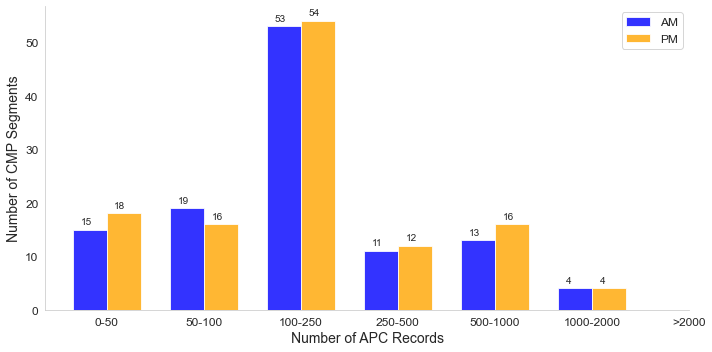

In [125]:
transit_speeds_samples(apc_cmp_speeds)

In [118]:
# 2019 speed
speeds2019 = pd.read_csv('S:\\CMP\\Transit\\Speed\\SF_CMP_Transit_Speeds_2019_Final.csv')
speeds2019.head(1)

,cmp_segid,year,source,period,avg_speed,std_dev,cov_2019,sample_size
0,2.0,2019,APC,AM,6.238537,2.124752,34.0585,41


Total number of segment-periods:  239


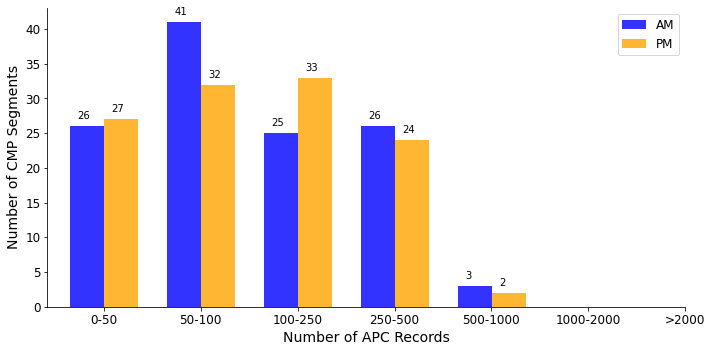

In [119]:
transit_speeds_samples(speeds2019)

In [218]:
speeds2021 = apc_cmp_speeds.copy()

In [121]:
speeds2019['cmp_segid'] = speeds2019['cmp_segid'].astype(int)
speeds2021['cmp_segid'] = speeds2021['cmp_segid'].astype(int)
speeds_compare = speeds2021.merge(speeds2019, on=['cmp_segid','period'])
speeds_compare.head(1)

,cmp_segid,avg_speed_x,std_dev_x,sample_size_x,cov,year_x,source_x,period,comments,length,group_id_x,group_range_x,year_y,source_y,avg_speed_y,std_dev_y,cov_2019,sample_size_y,group_id_y,group_range_y
0,5,9.635775,2.69025,219,27.919394,2021,APC,AM,"[15_INBOUND, T_OUTBOUND, KT_OUTBOUND]",2.359989,2,100-250,2019,APC,7.216951,1.053334,14.595273,12,0,0-50


In [122]:
def plot_unity(xdata, ydata):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None, linestyle='--', linewidth=1.0)
    
sns.set_style("whitegrid", {'axes.grid' : False})
newPal   = dict(AM = "#4878CF", PM = "#D65F5F")

def compare_two_cycles(df, x_col, y_col):
    g = sns.pairplot(x_vars=[x_col], y_vars=[y_col], data=df, hue="period", plot_kws={"s": 25}, height=5, palette=newPal)
    mn = min(df[x_col].min(), df[y_col].min())
    mx = max(df[x_col].max(), df[y_col].max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None, linestyle='--', linewidth=1.0)

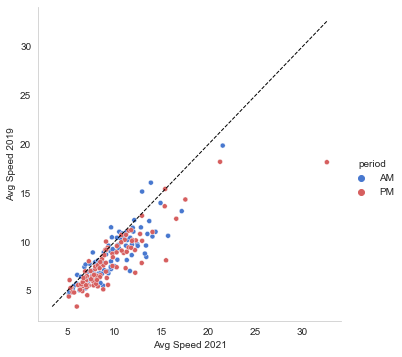

In [123]:
x_col = 'avg_speed_x'
y_col = 'avg_speed_y'

compare_two_cycles(speeds_compare, x_col, y_col)
plt.xlabel('Avg Speed 2021')
plt.ylabel('Avg Speed 2019')
plt.show()

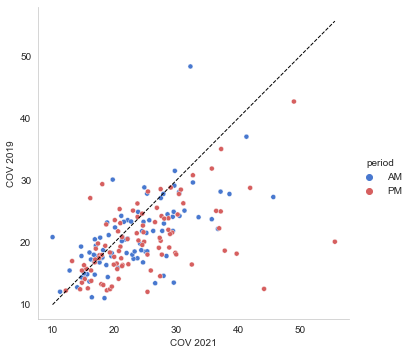

In [124]:
x_col = 'cov'
y_col = 'cov_2019'

compare_two_cycles(speeds_compare, x_col, y_col)
plt.xlabel('COV 2021')
plt.ylabel('COV 2019')
plt.show()